<a href="https://colab.research.google.com/github/CuAuPro/VGG16_MVTec/blob/main/ais_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Anomaly detection**

##AIS Elective Project

Implementation and test concept of transfer learning with convolutional neural networks (CNNs)

**Import modules**

In [1]:
# Import general modules
import os
from glob import glob
from imageio import imread
import time
from timeit import default_timer as timer

# Data science tools
import numpy as np
import pandas as pd


# Pytorch
import torch
from torch import optim, cuda
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary

import torchvision
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid

# Visualizations
import matplotlib.pyplot as plt

# Custom
import sys
sys.path.append('drive/MyDrive/ais_project/')

from lib.image import MyFunction, imshow, inv_transform_img
from lib.model import train, save_checkpoint, load_checkpoint, predict

In [2]:
# Import additional modules
from lib.utils import visualize_cam, Normalize
from lib.gradcam import GradCAM

In [ ]:
!ls

drive  sample_data


**Parameters**


In [3]:
# Parameters

# Location of data
DATAPATH = 'drive/MyDrive/ais_project/capsule/'
traindir = DATAPATH + 'train/'
valdir = DATAPATH + 'val/'
testdir = DATAPATH + 'test/'

model_path = 'drive/MyDrive/ais_project/vgg16-model.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 16

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.



##**Data preprocessing**

In [4]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=15),
        #transforms.ColorJitter(),
        #transforms.RandomHorizontalFlip(),
        #transforms.ToPILImage(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:


# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size= len(data['test']), shuffle=True),
    #'train': DataLoader(X_train, batch_size=batch_size, shuffle=True),
    #'val': DataLoader(X_val, batch_size=batch_size, shuffle=True),
    #'test': DataLoader(X_test, batch_size=batch_size, shuffle=True)
    
}

#dataset_sizes = {x: len(eval('X_'+x)) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(data[x]) for x in ['train', 'val', 'test']}
for x in ['train', 'val', 'test']:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = data['test'].classes
print(data['test'].classes)

Loaded 162 images under train
Loaded 38 images under val
Loaded 18 images under test
Classes: 
['anomaly', 'good']


###**Data overview**

In [ ]:
Source: https://www.mvtec.com/company/research/datasets/mvtec-ad (capsule)

18


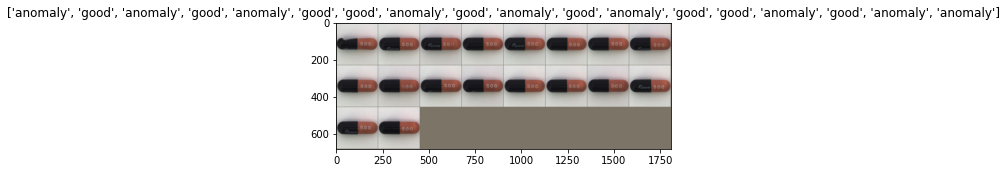

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(len(inputs))
# Plot test images
imshow(out, title=[class_names[x] for x in classes])

## **VGG16 Model**

In [7]:
# Import pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Dump model classifier structure
model.classifier



###**Add on Custom Classifier**

To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier in the already trained VGG network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [8]:
n_inputs = model.classifier
n_classes = 2

# Add on classifier
model.classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[0].in_features, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1)
    )
model.classifier

if train_on_gpu:
  model = model.to('cuda')
  print('Model to cuda')

  if multi_gpu:
      model = nn.DataParallel(model)
      print('Model to parallel cuda')

Model to cuda


In [ ]:
# Model parameters overview
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

In [ ]:
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

In [ ]:
# Look into model classes mapping.
data['test'].class_to_idx

{'anomaly': 0, 'good': 1}

In [ ]:
# Write model classes mapping.
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'anomaly'), (1, 'good')]

### Model train

Sources:

*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

*   https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/

*  https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce




In [ ]:
# Loss and optimizer
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    train_on_gpu,
    save_file_name=checkpoint_path,
    max_epochs_stop=10,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 3.2443 	Validation Loss: 2.6364
		Training Accuracy: 55.56%	 Validation Accuracy: 55.26%

Epoch: 1 	Training Loss: 1.2369 	Validation Loss: 1.0187
		Training Accuracy: 72.84%	 Validation Accuracy: 60.53%

Epoch: 2 	Training Loss: 0.6222 	Validation Loss: 0.3799
		Training Accuracy: 80.25%	 Validation Accuracy: 78.95%

Epoch: 3 	Training Loss: 0.3777 	Validation Loss: 0.3608
		Training Accuracy: 87.04%	 Validation Accuracy: 81.58%

Epoch: 4 	Training Loss: 0.2623 	Validation Loss: 0.4792
		Training Accuracy: 90.74%	 Validation Accuracy: 81.58%

Epoch: 5 	Training Loss: 0.2384 	Validation Loss: 0.2820
		Training Accuracy: 92.59%	 Validation Accuracy: 86.84%

Epoch: 6 	Training Loss: 0.0855 	Validation Loss: 0.7444
		Training Accuracy: 96.91%	 Validation Accuracy: 78.95%

Epoch: 7 	Training Loss: 0.0660 	Validation Loss: 0.3435
		Training Accuracy: 96.91%	 Validation Accuracy: 86.84%

Epoch: 8 	Training Loss: 0.0481 	Validation Lo

In [ ]:
save_checkpoint(model, model_path)

#### Load model (optional)

In [6]:
model, optimizer = load_checkpoint(model_path, multi_gpu, train_on_gpu)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

40,407,874 total parameters.
25,693,186 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 2

##**Training results**

Text(0.5, 1.0, 'Training and Validation Losses')

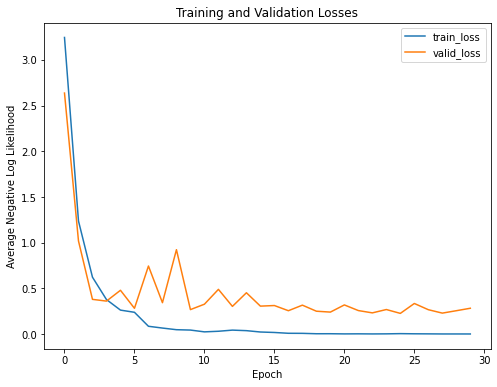

In [ ]:
# Plot Training and Validation Losses
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

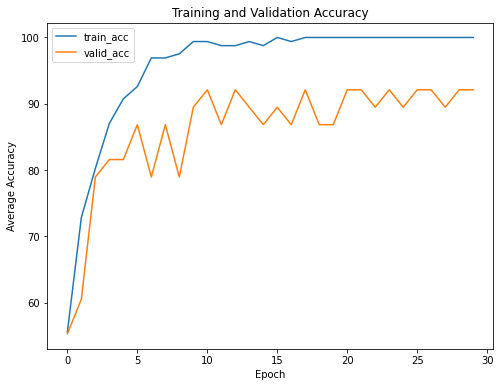

In [ ]:
# Plot Training and Validation Accuracies
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
          100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

assigning inputs_test and classes_test


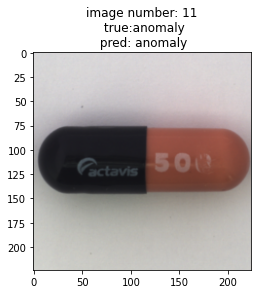

In [ ]:
# Get a batch of training data
try:
    inputs_test
except NameError:
  print('assigning inputs_test and classes_test')
  inputs_test, classes_test = next(iter(dataloaders['test']))

# Make a grid from batch
random_img = np.random.randint(0, len(inputs))
out = torchvision.utils.make_grid(inputs_test[random_img])
class_test = int(classes_test[random_img])

pred = predict(inputs_test[random_img], model, train_on_gpu)
pred_test = int(pred.indices)

title = ('image number: ' + str(random_img) + 
         '\n true:' + model.idx_to_class[class_test] + 
         '\n pred: ' + model.idx_to_class[pred_test])

imshow(out, title=title)



In [ ]:
# Testing...
#for data, target in iter(dataloaders['test']).next():
data = iter(dataloaders['test']).next()[0]
target = iter(dataloaders['test']).next()[1]
if 1 == 1:
    data_l = data[random_img].cuda().unsqueeze(0)
    target_l = target[random_img].to('cuda').unsqueeze(0)

    log_ps = model(data_l)
    
    # Convert to probabilities
    ps = torch.exp(log_ps)
    topk, topclass = ps.topk(2, dim=1)
    # Extract the actual classes and probabilities
    top_classes = [
        model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
    ]
    pred = torch.max(ps, dim=1)
    print(target_l)
    print(pred)

In [ ]:
# Testing...
model.idx_to_class[target_l.cpu().numpy()[0]],model.idx_to_class[int(pred.indices)]



[[7. 2.]
 [2. 7.]]


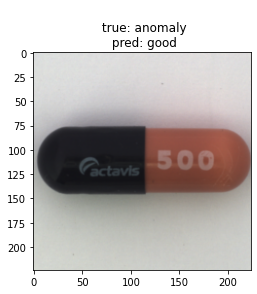

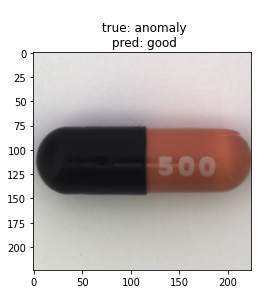

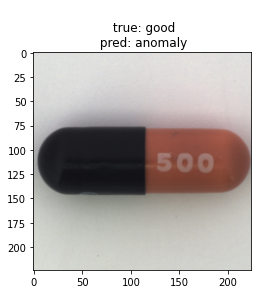

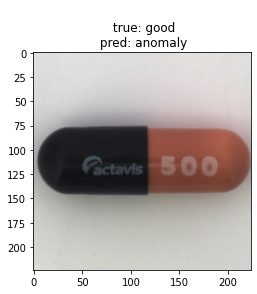

In [ ]:
inputs_test, classes_test = next(iter(dataloaders['test']))

outs = []
trues = []
preds = []
image_nrs = []
cm = np.zeros((2, 2))
for i in range(len(inputs_test)):

  class_test = int(classes_test[i])

  pred = predict(inputs_test[i], model, train_on_gpu)
  pred_test = int(pred.indices)

  cm[pred_test][class_test] += 1
  if class_test != pred_test:
    outs.append(torchvision.utils.make_grid(inputs_test[i]))
    
    trues.append(model.idx_to_class[class_test])
    preds.append(model.idx_to_class[pred_test])
    image_nrs.append(i)



print(cm)

for i, out in enumerate(outs):
  title = ('\n true: ' + trues[i] + 
           '\n pred: ' + preds[i])
  imshow(out, title=title)


In [ ]:
trues, preds, classes_test

(['anomaly', 'anomaly', 'good', 'good'],
 ['good', 'good', 'anomaly', 'anomaly'],
 tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]))

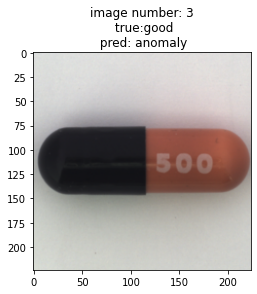

In [ ]:

idx = 0
image_nr = image_nrs[idx]
true = trues[idx]
pred = preds[idx]
out = outs[idx]
title = ('image number: ' + str(image_nr) + 
            '\n true:' + true + 
            '\n pred: ' + pred)

imshow(out, title=title)

##**Model visual explanation**

Grad-cam implementation. (Source: https://github.com/1Konny/gradcam_plus_plus-pytorch)

In [7]:
images, labels = next(iter(dataloaders['test']))
#predict(images[5], model, train_on_gpu=True)

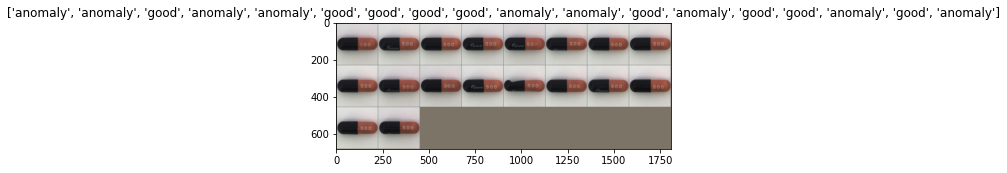

In [8]:
# Make a grid from batch
out = torchvision.utils.make_grid(images)
# Plot test images
imshow(out, title=[class_names[x] for x in labels])

In [9]:
input_tensor = images[12].to('cuda').unsqueeze(0) 
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [10]:
image = inv_transform_img(input_tensor)

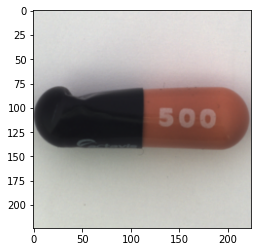

In [11]:
plt.imshow(image)

In [12]:
cam_dict = dict()
vgg_model_dict = dict(type='vgg', arch=model, layer_name='features', criterion=nn.NLLLoss(), input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
cam_dict['vgg'] = vgg_gradcam

saliency_map size : torch.Size([7, 7])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


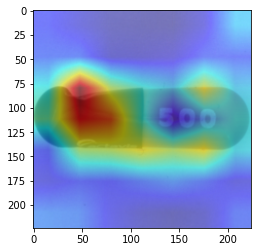

In [13]:
for gradcam in cam_dict.values():
    mask, _ = gradcam(input_tensor.requires_grad_())
    heatmap, result = visualize_cam(mask, image)
    plt.imshow(result)

#**TESTING WORKSPACE**

In [57]:
criterion = nn.NLLLoss()

In [62]:
import cv2
def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output
    print('backward_hook')
    return None
def forward_hook(module, input, output):
    activations['value'] = output
    print('forward_hook')
    return None
    
model.features.register_forward_hook(forward_hook),
model.features.register_backward_hook(backward_hook)

In [129]:
gradients = dict()
activations = dict()

In [130]:
model.eval
input_tensor.requires_grad_()
out = model(input_tensor)
ps = torch.exp(out)
pred = torch.max(ps, dim=1)
pred = pred.indices
loss = criterion(out, pred)
model.zero_grad()
loss.backward(retain_graph=False)

forward_hook
forward_hook
backward_hook
backward_hook


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [132]:
import torch.nn.functional as F
b, k, u, v = gradients['value'][0].size()
alpha = gradients['value'][0].view(b, k, -1).mean(2)
#alpha = F.relu(gradients.view(b, k, -1)).mean(2)
weights = alpha.view(b, k, 1, 1)

b, c, h, w = input_tensor.size()
saliency_map = (weights*activations['value']).sum(1, keepdim=True)
saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [137]:
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map.cpu().squeeze()), cv2.COLORMAP_JET)
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
b, g, r = heatmap.split(1)
heatmap = torch.cat([b, g, r])
heatmap = heatmap.cpu().numpy().transpose((1, 2, 0))
result = heatmap+image
result = np.divide(result, result.max())


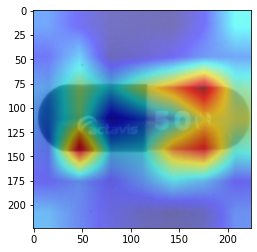

In [138]:
plt.imshow(result)